In [1]:
import os
import sys
import random
from pathlib import Path
import osgeo  #Needed for use on Windows only
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
%matplotlib inline

In [2]:
sys.path.append(r"../src/collectcube")
from samplegen import *

## Get random sample within polygon

aoi file has crs:epsg:32721


<Axes: >

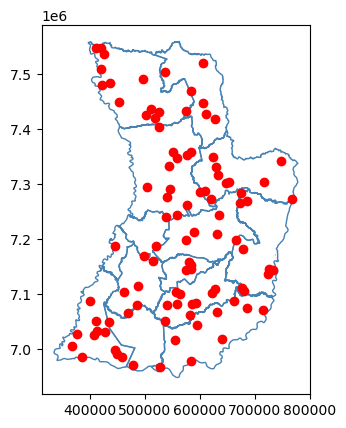

In [3]:
aoi_in = Path("../data/EParaguay.shp")
sampsize = 100
subpoly=None
gs = get_sample_in_poly(aoi_in, sampsize, subpoly)

fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
gs.plot(ax=ax, color='r')

## Shift points to centroids of ref ras and make sample boxes

ref_ras has crs:EPSG:8858
Reprojecting aoi file to match image crs


<Axes: >

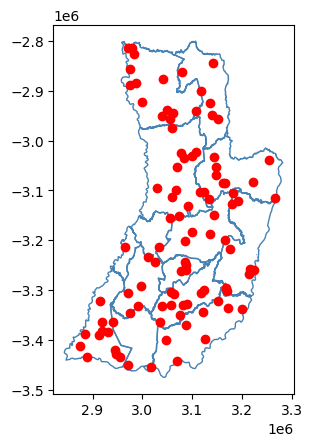

In [4]:
ref_ras = Path("../data/samp_ras.tif")

gs_shift = move_points_to_pixel_centroids(gs, ref_ras, write_pts=False)

## Plot again to make sure that crs is correctly matched
fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
if (gdf.crs != gs_shift.crs):
    print("Reprojecting aoi file to match image crs")
    gdf = gdf.to_crs(gs_shift.crs)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
gs_shift.plot(ax=ax, color='r')

In [8]:
poly_file_out = "C:/Users/klobw/Desktop/Testing/polys_test8.shp"
pt_file_out = "C:/Users/klobw/Desktop/Testing/pts_test2.shp"
res = 10
    
allpts = get_full_point_file(gs_shift, pt_file_out, res)

boxes = make_pixel_boxes_from_pts(allpts, poly_file_out, res)

polys overlapping image: 
                                             geometry
0  POLYGON ((3166715.000 -3199405.000, 3166715.00...
1  POLYGON ((3166705.000 -3199395.000, 3166705.00...
2  POLYGON ((3166715.000 -3199395.000, 3166715.00...
3  POLYGON ((3166725.000 -3199395.000, 3166725.00...
4  POLYGON ((3166705.000 -3199405.000, 3166705.00...
5  POLYGON ((3166725.000 -3199405.000, 3166725.00...
6  POLYGON ((3166705.000 -3199415.000, 3166705.00...
7  POLYGON ((3166715.000 -3199415.000, 3166715.00...
8  POLYGON ((3166725.000 -3199415.000, 3166725.00...


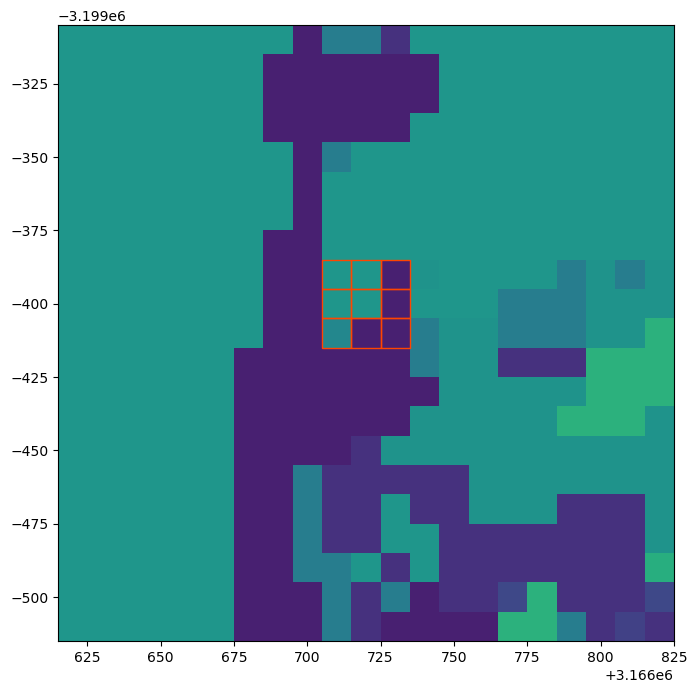

In [9]:
zoom = find_poly_on_image(7, ref_ras, boxes)

## build mosaic

In [ ]:
model = 'base1000'
out_path = Path('/home/downspout-cel/paraguay_lc/mosaics')
cell_list = '/home/downspout-cel/paraguay_lc/mosaics/lists/Tile6list.csv'
#mosaicked = mosaic_cells(basic_config['grid_cells'], basic_config['smooth_dir'], 'comp', model, out_path)
mosaicked = mosaic_cells(cell_list, basic_config['smooth_dir'], 'comp', model, out_path)

## view mosaic

In [ ]:
fig = plt.figsize=(30,30)
l_rgb = get_rbg_img(mosaicked,single_plot_params['gamma'])
plt.imshow(l_rgb)
plt.title("new moasic")
plt.axis('off');